In [1]:
from plotting import plot_city_tour,plot_ea_convergence
from utils import DataType,DATA_TYPE_2_DATA_STRING,parse_tsp_data,DATA_2_OPTIMUM_TOUR,get_distance_matrix

In [2]:
from deap import base, creator, tools
import numpy as np
import pandas as pd
import random
import math
from functools import partial
from typing import List
from time import perf_counter


In [3]:
# --- Experiment-Parameter (angepasst für schnellere Laufzeit) ---
# Für finale Ergebnisse können diese Werte wieder erhöht werden (z.B. NUM_RUNS=30, NUM_GENERATIONS=200)
NUM_RUNS = 2              # Reduziert von 10 für schnellere Demonstration
NUM_GENERATIONS = 100    # Reduziert von 200
POP_SIZES = [50]
TRUNCATION_PERCENTAGE = 0.2
MUTATION_RATE = 0.2
# Tabu-Search-Parameter
TS_ITERATIONS = 10        # Reduziert von 15, um die teure lokale Suche zu beschleunigen
TABU_LIST_SIZE = 20
# Hybrid-Parameter

HYBRID_TS_START_GENERATION = int(NUM_GENERATIONS * .9)
HYBRID_TS_IMPROVE_PERCENTAGE = 0.2

data_type = DataType.BERLIN52

In [4]:
# Daten direkt aus dem String laden
OPTIMUM_TOUR = DATA_2_OPTIMUM_TOUR[data_type] 
DATA_STRING = DATA_TYPE_2_DATA_STRING[data_type]

coords = parse_tsp_data(DATA_STRING)

points = [(i, x, y) for i, (x, y) in enumerate(coords)]


dist_matrix = get_distance_matrix(coords)
NUM_CITIES = len(coords)


In [5]:

def calculate_tour_length(tour: List[int], dist_matrix: np.ndarray, fitness_tracker=None) -> float:
    if fitness_tracker is not None:
        fitness_tracker['count'] += 1
    tour_array = np.array(tour)
    from_indices = tour_array
    to_indices = np.roll(tour_array, -1)
    return np.sum(dist_matrix[from_indices, to_indices])

def _find_neighborhood(solution, dist_matrix, fitness_tracker=None, n_opt=1):
    neighborhood = []
    solution_length = len(solution)

    for i in range(1, solution_length - n_opt):
        idx1 = list(range(i, i + n_opt))

        for j in range(1, solution_length - n_opt):
            idx2 = list(range(j, j + n_opt))

            if set(idx1) & set(idx2):
                continue

            new_solution = solution[:]
            for k in range(n_opt):
                new_solution[idx1[k]], new_solution[idx2[k]] = (
                    solution[idx2[k]],
                    solution[idx1[k]]
                )

            total_cost = calculate_tour_length(new_solution, dist_matrix, fitness_tracker)
            candidate = new_solution + [total_cost]

            if candidate not in neighborhood:
                neighborhood.append(candidate)

    neighborhood.sort(key=lambda x: x[-1])
    return neighborhood

def tabu_search(initial_solution, initial_cost, dist_matrix, iterations, tabu_size, n_opt=1, fitness_tracker=None):
    solution = initial_solution
    best_solution = initial_solution
    best_cost = initial_cost
    tabu_list = []
    iteration = 0

    while iteration < iterations:
        neighborhood = _find_neighborhood(solution, dist_matrix, fitness_tracker=fitness_tracker, n_opt=n_opt)
        move_accepted = False
        candidate_index = 0

        while not move_accepted and candidate_index < len(neighborhood):
            candidate = neighborhood[candidate_index]
            candidate_solution = candidate[:-1]
            candidate_cost = candidate[-1]

            diff_current = []
            diff_candidate = []
            for a, b in zip(solution, candidate_solution):
                if a != b:
                    diff_current.append(a)
                    diff_candidate.append(b)
                if len(diff_current) == n_opt:
                    break

            move = diff_current + diff_candidate
            reverse_move = diff_candidate + diff_current

            if move not in tabu_list and reverse_move not in tabu_list:
                tabu_list.append(move)
                solution = candidate_solution
                move_accepted = True

                if candidate_cost < best_cost:
                    best_cost = candidate_cost
                    best_solution = candidate_solution

            candidate_index += 1

        if len(tabu_list) > tabu_size:
            tabu_list.pop(0)

        iteration += 1

    return best_solution, best_cost

def evaluation(individual: List[int], dist_matrix: np.ndarray, fitness_tracker=None):
    return (calculate_tour_length(individual, dist_matrix, fitness_tracker),)

def record_log(gen, population, log_book: List, fitness_counter: int) -> List:
    best = tools.selBest(population, 1)[0]
    log_book.append([
        gen,
        fitness_counter,
        best.fitness.values[0],
        np.mean([ind.fitness.values[0] for ind in population])
    ])
    return log_book

def run_hybrid_ea(pop_size: int, num_generations: int, dist_matrix: np.ndarray):
    fitness_tracker = {'count': 0}

    if not hasattr(creator, "FitnessMin"):
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    if not hasattr(creator, "Individual"):
        creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("indices", random.sample, range(NUM_CITIES), NUM_CITIES)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    evaluate = partial(evaluation, dist_matrix=dist_matrix, fitness_tracker=fitness_tracker)
    toolbox.register("evaluate", evaluate)
    toolbox.register("mate", tools.cxOrdered)
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
    toolbox.register("select", tools.selBest)

    pop = toolbox.population(n=pop_size)
    logbook = []

    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    logbook = record_log(0, pop, logbook, fitness_counter=fitness_tracker['count'])
    tabu_total_time = 0.0

    for gen in range(1, num_generations + 1):
        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))

        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < 0.9:
                toolbox.mate(child1, child2)
                del child1.fitness.values, child2.fitness.values

        for mutant in offspring:
            if random.random() < 0.2:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        if gen >= HYBRID_TS_START_GENERATION:
            gen_tabu_start = perf_counter()
            offspring.sort(key=lambda ind: ind.fitness.values[0] if ind.fitness.valid else float('inf'))
            num_to_improve = max(1, int(pop_size * HYBRID_TS_IMPROVE_PERCENTAGE))

            for i in range(num_to_improve):
                tour = offspring[i]
                tour_indices = list(tour)
                cost = tour.fitness.values[0] if tour.fitness.valid else calculate_tour_length(tour_indices, dist_matrix, fitness_tracker)

                improved_tour, improved_cost = tabu_search(
                    tour_indices,
                    cost,
                    dist_matrix,
                    TS_ITERATIONS,
                    TABU_LIST_SIZE,
                    n_opt=1,
                    fitness_tracker=fitness_tracker
                )

                if len(set(improved_tour)) != NUM_CITIES:
                    raise ValueError("Some cities were lost during Tabu Search")

                offspring[i][:] = improved_tour
                offspring[i].fitness.values = (improved_cost,)

            print(f"    [GEN {gen}] Tabu search time: {perf_counter() - gen_tabu_start:.2f} sec")

        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = list(map(toolbox.evaluate, invalid_ind))
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        pop[:] = offspring
        logbook = record_log(gen, pop, logbook, fitness_counter=fitness_tracker['count'])

    print(f"  >> [Hybrid-EA] Total Tabu search time this run: {tabu_total_time:.2f} seconds")

    best_ind = tools.selBest(pop, 1)[0]
    return best_ind.fitness.values[0], list(best_ind), pd.DataFrame(
        logbook,
        columns=['Generation', 'Total_Fitness_Evaluations', 'Best_Fitness_Generation', 'Avg_Fitness_Generation']
    )

def run_multiple_configs():
    all_results = {}
    all_logs = {}
    best_tours = {}

    for pop_size in POP_SIZES:
        key = f"Hybrid_{pop_size}"
        print(f"  -> Starting runs for: {key}")

        final_fitnesses_run = []
        run_logs = []
        best_tour_run = None
        best_fitness_run = float('inf')

        for i in range(NUM_RUNS):
            print(f" {key}  -> Run {i+1}/{NUM_RUNS}...", end="")
            final_fitness, final_tour, log_data = run_hybrid_ea(pop_size, NUM_GENERATIONS, dist_matrix)
            final_fitnesses_run.append(final_fitness)
            run_logs.append(log_data)

            if final_fitness < best_fitness_run:
                best_fitness_run = final_fitness
                best_tour_run = final_tour
            print(" done")

        all_results[key] = final_fitnesses_run
        all_logs[key] = run_logs
        best_tours[key] = best_tour_run

    return all_results, all_logs, best_tours


In [6]:
all_results, all_logs, best_tours = run_multiple_configs()

  -> Starting runs for: Hybrid_50
 Hybrid_50  -> Run 1/2...    [GEN 90] Tabu search time: 9.45 sec
    [GEN 91] Tabu search time: 9.28 sec
    [GEN 92] Tabu search time: 9.32 sec
    [GEN 93] Tabu search time: 9.62 sec
    [GEN 94] Tabu search time: 9.19 sec
    [GEN 95] Tabu search time: 9.21 sec
    [GEN 96] Tabu search time: 9.67 sec
    [GEN 97] Tabu search time: 10.25 sec
    [GEN 98] Tabu search time: 9.53 sec
    [GEN 99] Tabu search time: 8.67 sec
    [GEN 100] Tabu search time: 9.21 sec
  >> [Hybrid-EA] Total Tabu search time this run: 0.00 seconds
 done
 Hybrid_50  -> Run 2/2...    [GEN 90] Tabu search time: 8.80 sec
    [GEN 91] Tabu search time: 9.52 sec
    [GEN 92] Tabu search time: 9.20 sec
    [GEN 93] Tabu search time: 9.22 sec
    [GEN 94] Tabu search time: 8.90 sec
    [GEN 95] Tabu search time: 9.15 sec
    [GEN 96] Tabu search time: 8.99 sec
    [GEN 97] Tabu search time: 9.18 sec
    [GEN 98] Tabu search time: 8.98 sec
    [GEN 99] Tabu search time: 9.04 sec
    [

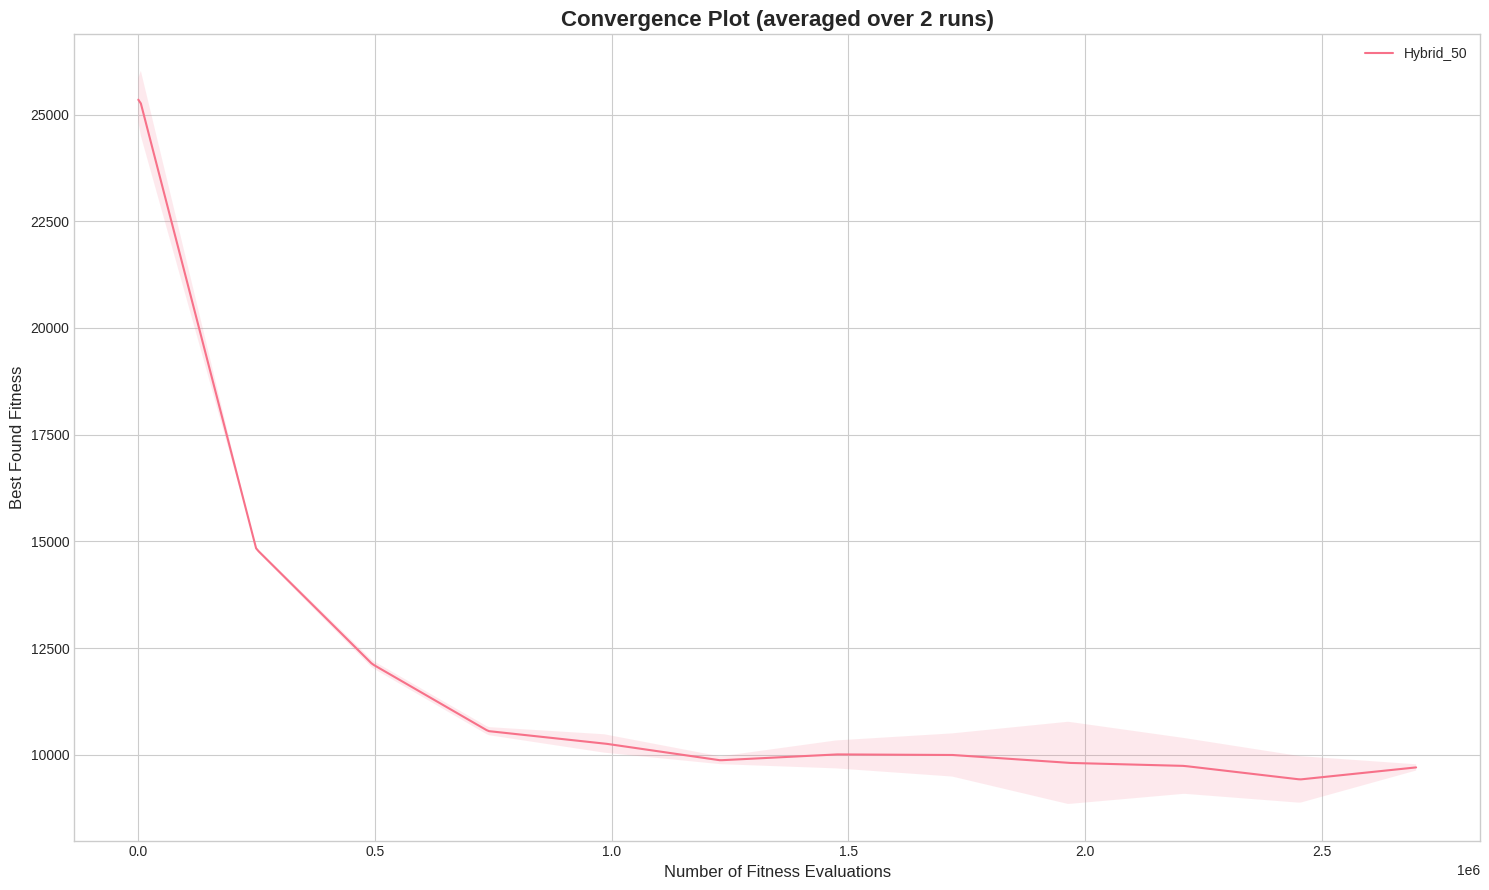

In [7]:
plot_ea_convergence(all_logs,NUM_RUNS)


Best tour found comes from 'Hybrid_50' with a length of 9628.60


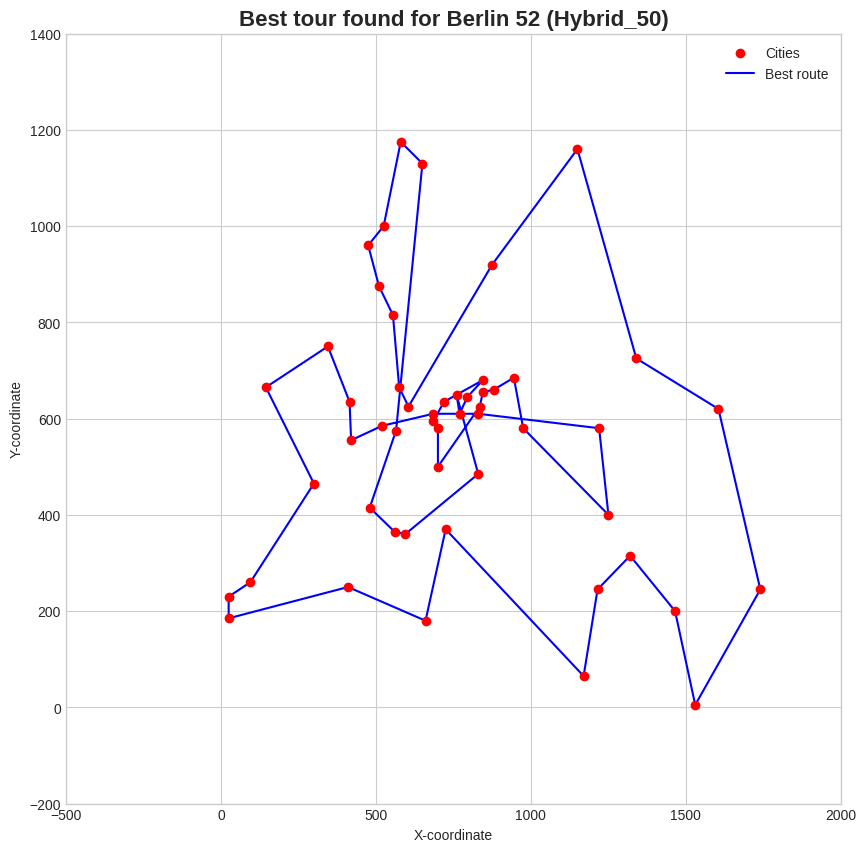

In [8]:
plot_city_tour(all_results,best_tours,coords,data_type)